In [64]:
import torch
import torch.nn as nn #related to neural networks
import torch.optim as optim #optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
import timm
import numpy as np
import sys
import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)



System Version: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 13:22:57) [Clang 14.0.6 ]
PyTorch version 2.4.1
Torchvision version 0.19.1
Numpy version 1.26.4


In [65]:
class CircuitDiagramDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

# Use data augmentation to apply random transformation to diagrams to create variations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
     ])

dataset = CircuitDiagramDataset(
    data_dir='components/train', transform=transform #reads the diagram from this folder
)
image, label = dataset[100]
image.shape

# plt.imshow(image.permute(1, 2, 0).numpy())
# plt.title(f"Label: {dataset.classes[label]}")
# plt.show()

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

for images, labels in dataloader:  
    break


In [66]:
class CircuitDiagramClassifier(nn.Module):
    def __init__(self, num_classes=41):
        super(CircuitDiagramClassifier, self).__init__() # Calls constructor of parent class nn.Module
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)  # Creates a pretrained model
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flattens input tensor to 1D tensor
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.72it/s]


Epoch 1/10 - Train loss: 3.932949580797335, Validation loss: 3.875404253238585, Accuracy: 0.036585365853658534


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.58it/s]


Epoch 2/10 - Train loss: 3.866441267292674, Validation loss: 3.8592957170998177, Accuracy: 0.054878048780487805


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.15it/s]


Epoch 3/10 - Train loss: 3.830524965030391, Validation loss: 3.7551470297138865, Accuracy: 0.06097560975609756


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 28.81it/s]


Epoch 4/10 - Train loss: 3.7369479580623346, Validation loss: 3.564966123278548, Accuracy: 0.04878048780487805


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.42it/s]


Epoch 5/10 - Train loss: 3.5636192560195923, Validation loss: 2.97477767816404, Accuracy: 0.12195121951219512


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.04it/s]


Epoch 6/10 - Train loss: 3.296255268701693, Validation loss: 2.737026250943905, Accuracy: 0.14634146341463414


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.02it/s]


Epoch 7/10 - Train loss: 3.239217412181017, Validation loss: 2.7186740167984147, Accuracy: 0.20121951219512196


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.06it/s]


Epoch 8/10 - Train loss: 2.9490205601948065, Validation loss: 2.527520940071199, Accuracy: 0.23170731707317074


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.09it/s]


Epoch 9/10 - Train loss: 2.9225278758421176, Validation loss: 2.372347104113276, Accuracy: 0.25


Validation loop: 100%|██████████| 82/82 [00:02<00:00, 29.25it/s]

Epoch 10/10 - Train loss: 2.792031320129953, Validation loss: 2.3580865351165214, Accuracy: 0.18292682926829268


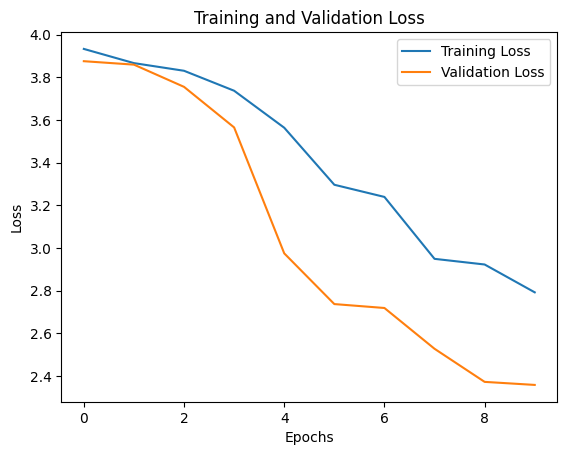

In [67]:
model = CircuitDiagramClassifier()

example_out = model(images)
example_out.shape # Check output shape [batch_size, num_classes]

criterion = nn.CrossEntropyLoss()  # Defines the loss function
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion(example_out, labels)

train_folder = 'components/train'
valid_folder = 'components/valid'
test_folder = 'components/test'

train_dataset = CircuitDiagramDataset(train_folder, transform=transform)
val_dataset = CircuitDiagramDataset(valid_folder, transform=transform)
test_dataset = CircuitDiagramDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

num_epochs = 10
train_losses, val_losses = [], []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = CircuitDiagramClassifier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjusts learning rate during training dynamically

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm.tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0  # Initialize correct predictions count
    total = 0    # Initialize total predictions count
    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)  # Count total predictions
    val_loss = running_loss / len(val_loader.dataset)  # Calculate average loss
    val_losses.append(val_loss)

    # Calculate overall accuracy for the validation set
    accuracy = correct / total if total > 0 else 0
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}, Accuracy: {accuracy}")
    scheduler.step()
    
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
